In [371]:
!pip install ta
!pip install quantreo
!pip install feature-engine

#### LOAD LIBRARIES

In [469]:
import pandas as pd
import numpy as np
import seaborn as sns
import ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import quantreo.features_engineering as fe
from sklearn.feature_selection import RFECV
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score

#### LOAD DATA

In [415]:
spy_data = pd.read_pickle('SPY_.pickle')
vix_data = pd.read_pickle('VIX.pkl')
spy_win_loss_outcome = pd.read_csv('SPY_good_bad_patterns.csv')


#### DATA EXPLORATION & CLEANING

### VIX

In [374]:
vix_data.head()

,timestamp,open,high,low,close,volume
0,2023-04-03 09:31:00-04:00,19.58,19.58,19.53,19.54,0.0
1,2023-04-03 09:32:00-04:00,19.52,19.52,19.52,19.52,0.0
2,2023-04-03 09:33:00-04:00,19.51,19.51,19.49,19.49,0.0
3,2023-04-03 09:34:00-04:00,19.47,19.47,19.46,19.46,0.0
4,2023-04-03 09:35:00-04:00,19.47,19.47,19.45,19.45,0.0


In [375]:
vix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175299 entries, 0 to 175298
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype                           
---  ------     --------------   -----                           
 0   timestamp  175299 non-null  datetime64[ns, America/New_York]
 1   open       175299 non-null  float64                         
 2   high       175299 non-null  float64                         
 3   low        175299 non-null  float64                         
 4   close      175299 non-null  float64                         
 5   volume     175299 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5)
memory usage: 8.0 MB


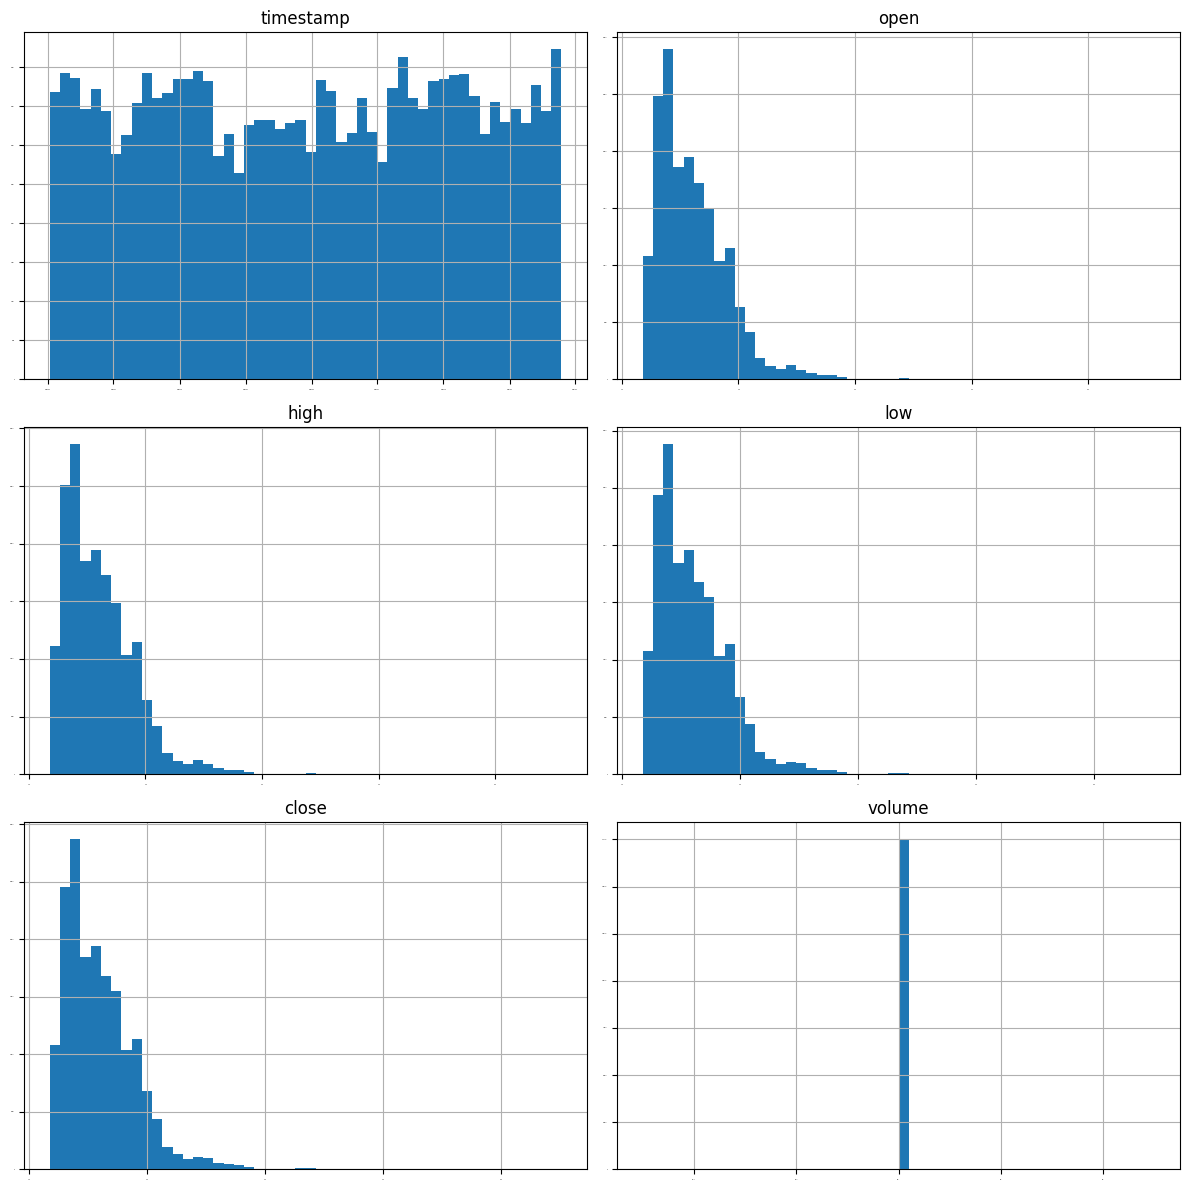

In [376]:
vix_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

The vix data is evidently skewed as expected. Taking the log of the close price can improve its predictive power in a linear model.

SPY_OUTCOME

In [416]:
spy_win_loss_outcome.head()

,Start Date,Open Price (11 AM),Status,Lowest Candle Time,Lowest Price,First Higher Candle Time,First Higher Price,Highest Candle Time,Highest Price,Last Candle Time,...,Weekday,11am Close,target_date,outcome,Partial W/L,pattern,pattern_5,vix_regime,observation,observation_5
0,2020-01-02,323.94,Good,2020-01-03 10:00:00,319.69,2020-01-10 10:00:00,327.5000,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,3,323.63,2020-01-10 16:00:00,W,PL,NaN,NaN,Low,NaN,NaN
1,2020-01-03,320.15,Good,2020-01-03 11:00:00,320.06,2020-01-07 10:00:00,323.9100,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,4,320.55,2020-01-10 16:00:00,W,PW,NaN,NaN,Low,NaN,NaN
2,2020-01-06,320.71,Good,2020-01-06 13:00:00,320.06,2020-01-07 11:00:00,323.9300,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,0,320.72,2020-01-10 16:00:00,W,PW,NaN,NaN,Low,NaN,NaN
3,2020-01-07,323.76,Good,2020-01-08 13:00:00,320.89,2020-01-10 10:00:00,327.5000,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,1,323.41,2020-01-10 16:00:00,W,PL,WWW,NaN,Low,WWW_Low,NaN
4,2020-01-08,323.26,Good,2020-01-08 13:00:00,320.89,2020-01-09 15:00:00,326.5598,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,2,323.12,2020-01-10 16:00:00,W,PL,WWW,NaN,Low,WWW_Low,NaN


In [417]:
spy_win_loss_outcome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Start Date                1343 non-null   object 
 1   Open Price (11 AM)        1343 non-null   float64
 2   Status                    1343 non-null   object 
 3   Lowest Candle Time        1343 non-null   object 
 4   Lowest Price              1343 non-null   float64
 5   First Higher Candle Time  798 non-null    object 
 6   First Higher Price        798 non-null    float64
 7   Highest Candle Time       1343 non-null   object 
 8   Highest Price             1343 non-null   float64
 9   Last Candle Time          1343 non-null   object 
 10  Last Price                1343 non-null   float64
 11  Around Earning            1343 non-null   int64  
 12  VIX                       1337 non-null   float64
 13  Weekday                   1343 non-null   int64  
 14  11am Clo

SPY

In [379]:
spy_data.head()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
timestamp,,,,,,,,,,,,,,,,,,
2023-04-03 09:36:00-04:00,409.5500,409.7405,409.78,409.4805,0.381196,0.381196,0.381196,0.381196,9.334125e+08,9.334125e+08,9.334125e+08,9.334125e+08,0.0,-6.169928e+05,-6.169928e+05,-6.169928e+05,-6.169928e+05,0.0
2023-04-03 09:37:00-04:00,409.7500,409.7700,409.79,409.6300,0.378447,0.378447,0.378447,0.378447,9.338911e+08,9.338911e+08,9.338911e+08,9.338911e+08,0.0,-6.173091e+05,-6.173091e+05,-6.173091e+05,-6.173091e+05,0.0
2023-04-03 09:38:00-04:00,409.7900,409.8100,409.87,409.7300,0.373660,0.373660,0.373660,0.373660,9.340051e+08,9.340051e+08,9.340051e+08,9.340051e+08,0.0,-6.173845e+05,-6.173845e+05,-6.173845e+05,-6.173845e+05,0.0
2023-04-03 09:39:00-04:00,409.8101,409.8400,409.86,409.7318,0.371429,0.371429,0.371429,0.371429,9.340507e+08,9.340507e+08,9.340507e+08,9.340507e+08,0.0,-6.174146e+05,-6.174146e+05,-6.174146e+05,-6.174146e+05,0.0
2023-04-03 09:40:00-04:00,409.8600,409.7899,409.91,409.7564,0.375319,0.375319,0.375319,0.375319,9.383326e+08,9.383326e+08,9.383326e+08,9.383326e+08,0.0,7.578217e+07,7.578217e+07,7.578217e+07,7.578217e+07,0.0


In [380]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166500 entries, 2023-04-03 09:36:00-04:00 to 2024-12-20 15:59:00-05:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_Open          166500 non-null  float64
 1   Spot_Close         166500 non-null  float64
 2   Spot_High          166500 non-null  float64
 3   Spot_Low           166500 non-null  float64
 4   PCT_EPS_1mo_Open   166500 non-null  float64
 5   PCT_EPS_1mo_Close  166500 non-null  float64
 6   PCT_EPS_1mo_High   166500 non-null  float64
 7   PCT_EPS_1mo_Low    166500 non-null  float64
 8   open_abs_gex       166500 non-null  float64
 9   high_abs_gex       166500 non-null  float64
 10  low_abs_gex        166500 non-null  float64
 11  close_abs_gex      166500 non-null  float64
 12  volume_abs_gex     166500 non-null  float64
 13  open_net_gex       166500 non-null  float64
 14  high_net_gex       166500 non-null  float64
 15  low_n

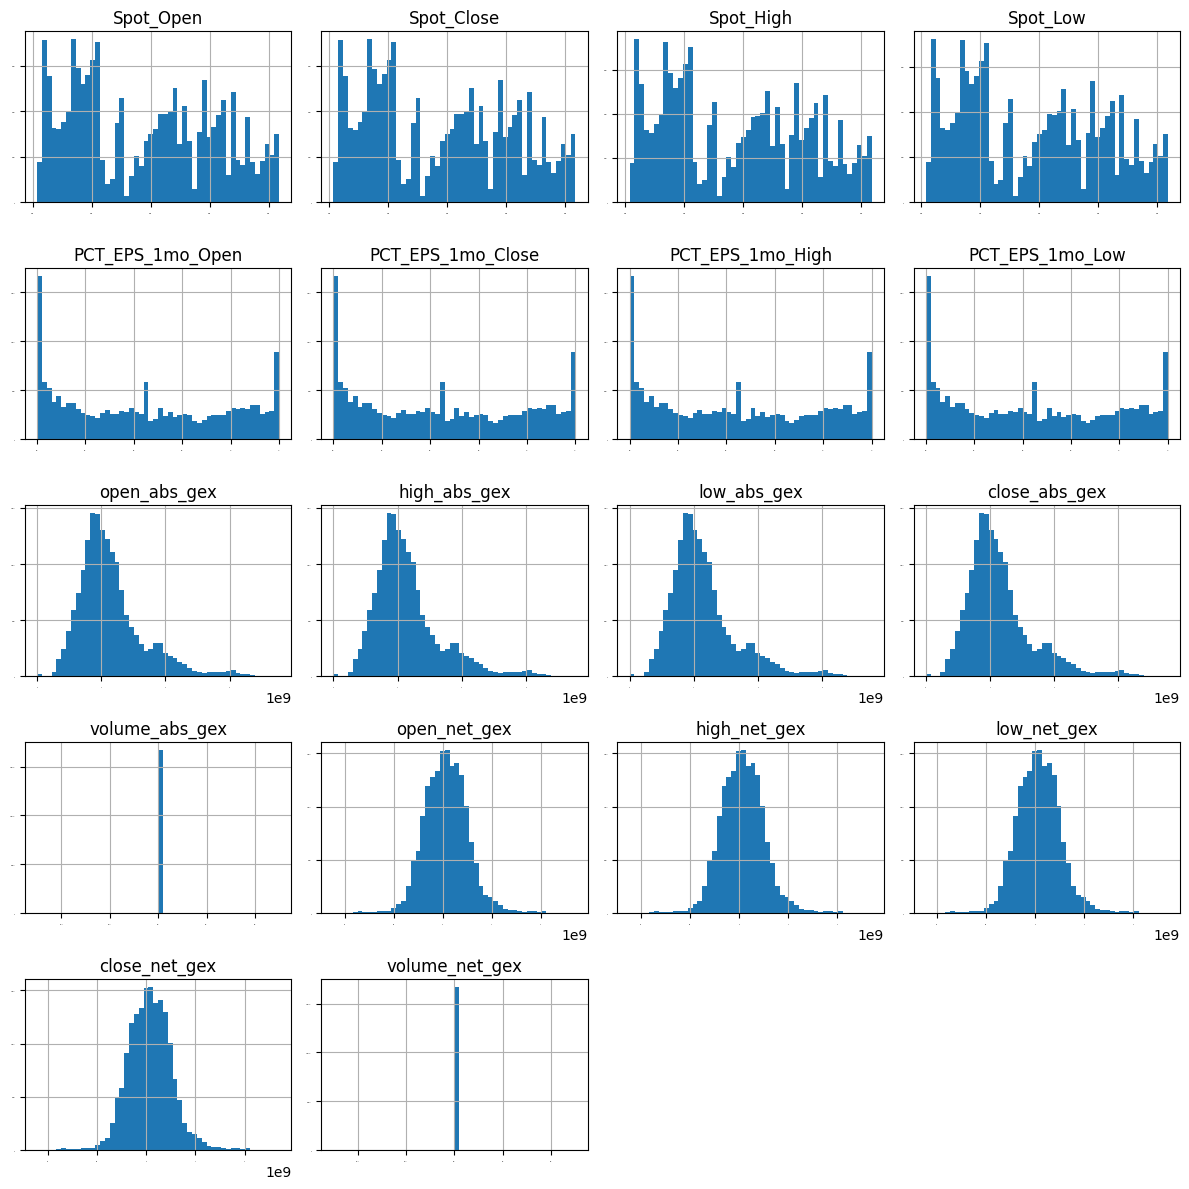

In [381]:
spy_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

#### SUMMARY STATISTICS

In [382]:
spy_data.describe()

,Spot_Open,Spot_Close,Spot_High,Spot_Low,PCT_EPS_1mo_Open,PCT_EPS_1mo_Close,PCT_EPS_1mo_High,PCT_EPS_1mo_Low,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex
count,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,166500.000000,1.665000e+05,1.665000e+05,1.665000e+05,1.665000e+05,166500.0,1.665000e+05,1.665000e+05,1.665000e+05,1.665000e+05,166500.0
mean,495.017645,495.017798,495.116255,494.915384,0.451943,0.451943,0.451943,0.451943,1.146558e+09,1.146558e+09,1.146558e+09,1.146558e+09,0.0,7.440525e+07,7.440525e+07,7.440525e+07,7.440525e+07,0.0
std,59.336326,59.335997,59.341300,59.330473,0.329833,0.329833,0.329833,0.329833,5.044058e+08,5.044058e+08,5.044058e+08,5.044058e+08,0.0,4.511821e+08,4.511821e+08,4.511821e+08,4.511821e+08,0.0
min,403.790000,403.795000,403.970000,403.740000,0.000118,0.000118,0.000118,0.000118,-7.000000e-06,-7.000000e-06,-7.000000e-06,-7.000000e-06,0.0,-2.228432e+09,-2.228432e+09,-2.228432e+09,-2.228432e+09,0.0
25%,440.910000,440.910000,440.980000,440.830000,0.136273,0.136273,0.136273,0.136273,8.192255e+08,8.192255e+08,8.192255e+08,8.192255e+08,0.0,-2.250616e+08,-2.250616e+08,-2.250616e+08,-2.250616e+08,0.0
50%,495.800000,495.800000,495.897500,495.692500,0.432922,0.432922,0.432922,0.432922,1.041204e+09,1.041204e+09,1.041204e+09,1.041204e+09,0.0,6.837704e+07,6.837704e+07,6.837704e+07,6.837704e+07,0.0
75%,545.815000,545.810000,545.920000,545.700000,0.762022,0.762022,0.762022,0.762022,1.337658e+09,1.337658e+09,1.337658e+09,1.337658e+09,0.0,3.548911e+08,3.548911e+08,3.548911e+08,3.548911e+08,0.0
max,609.015000,609.010000,609.070000,608.850000,1.000000,1.000000,1.000000,1.000000,3.771437e+09,3.771437e+09,3.771437e+09,3.771437e+09,0.0,2.705825e+09,2.705825e+09,2.705825e+09,2.705825e+09,0.0


In [383]:
vix_data.describe()

,open,high,low,close,volume
count,175299.000000,175299.000000,175299.000000,175299.000000,175299.0
mean,16.074896,16.088587,16.061518,16.075085,0.0
std,3.053062,3.062401,3.043772,3.053186,0.0
min,11.780000,11.800000,11.780000,11.790000,0.0
25%,13.750000,13.760000,13.740000,13.750000,0.0
50%,15.510000,15.520000,15.500000,15.510000,0.0
75%,17.680000,17.690000,17.660000,17.670000,0.0
max,55.680000,55.680000,55.110000,55.110000,0.0


All dataset have zero filled volume values, so they all have to be dropped.

In [384]:
def data_cleaning(df):
    '''
    This cleans the dataset by eliminating zero filled columns and unnecessary negative absolute gamma exposure values

    parameters:
    df: dataframe
    asset_name: str

    returns:
    df_copy: dataframe

    '''
    df_copy = df.copy()

    #remove rows with negative gamma exposure if the column exist in the dataset
    if 'close_abs_gex' in df_copy.columns:
        df_copy = df_copy.drop(df_copy[df_copy['close_abs_gex'] < 0].index)

    # Drop volume_abs_gex and volume_net_gex, if they exist (because they contain zero values)
    for col in ['volume_abs_gex', 'volume_net_gex', 'volume']:
        if col in df_copy.columns:
            df_copy = df_copy.drop(columns=[col])

    # Rename Spot columns to standard names, only if they exist
    rename_map = {
        'Spot_Open': 'open',
        'Spot_High': 'high',
        'Spot_Close': 'close',
        'Spot_Low': 'low'}

    existing_rename_map = {k: v for k, v in rename_map.items() if k in df_copy.columns}
    df_copy = df_copy.rename(columns=existing_rename_map)

    return df_copy


In [385]:
def previous_day_data(df, asset):
    '''
    The function generates previous close price and close_net_gex values for the previous day until the past 5 days.

    parameters:
    df: dataframe
    asset: str, asset name

    returns:
    prev_day_agg: dataframe
    '''
    # From raw (untrimmed) data
    raw_df = df.copy()
    # Check if datetime is a column or index
    if 'timestamp' in raw_df.columns:
        raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])
    else:
        raw_df['timestamp'] = pd.to_datetime(raw_df.index)

    prev_day_col = {
        'close': 'last',
        'close_net_gex' : 'last'}


    #Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in prev_day_col.items() if k in raw_df.columns}
    prev_day_agg = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).shift(1)
    prev_2day_agg = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).shift(2)
    prev_3day_agg = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).shift(3)
    prev_4day_agg = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).shift(4)
    prev_5day_agg = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).shift(5)
    prev_day_agg.columns = [f'prev_day_{col}_{asset}' for col in prev_day_agg.columns]
    prev_2day_agg.columns = [f'prev_2day_{col}_{asset}' for col in prev_2day_agg.columns]
    prev_3day_agg.columns = [f'prev_3day_{col}_{asset}' for col in prev_3day_agg.columns]
    prev_4day_agg.columns = [f'prev_4day_{col}_{asset}' for col in prev_4day_agg.columns]
    prev_5day_agg.columns = [f'prev_5day_{col}_{asset}' for col in prev_5day_agg.columns]
    prev_day_agg.index.name = 'timestamp'
    prev_2day_agg.index.name = 'timestamp'
    prev_3day_agg.index.name = 'timestamp'
    prev_4day_agg.index.name = 'timestamp'
    prev_5day_agg.index.name = 'timestamp'
    prev_day_agg = pd.concat([prev_day_agg, prev_2day_agg, prev_3day_agg, prev_4day_agg, prev_5day_agg], axis=1)

    return prev_day_agg


In [386]:
def resample_minute_data(df, name):
    '''
    This resamples the minute data into daily data, but until 11 am that day.

    parameters:
    df: dataframe
    name: asset name str

    returns:
    agg_df: dataframe

    '''
    df_copy = df.copy()

    # Check if datetime is a column or index
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy['time'] = df_copy['timestamp'].dt.time

    #select data upuntil 11 am that day
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    agg_map = {
        'open': 'first',
        'close': 'last',
        'high': 'max',
        'low': 'min',
        'PCT_EPS_1mo_Open': 'first',
        'PCT_EPS_1mo_Close': 'last',
        'PCT_EPS_1mo_High': 'max',
        'PCT_EPS_1mo_Low': 'min',
        'open_abs_gex': 'first',
        'high_abs_gex': 'max',
        'low_abs_gex' : 'min',
        'close_abs_gex' : 'last',
        'open_net_gex': 'first',
        'high_net_gex' : 'max',
        'low_net_gex' : 'min',
       'close_net_gex' : 'last'}


    # Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in agg_map.items() if k in df_copy.columns}
    agg_df = df_copy.groupby('date').agg(selected_agg).reset_index()

    # Rename columns with prefix (except 'date')
    agg_df.rename(columns=lambda col: col if col == 'date' else f'11am_{name}_{col}', inplace=True)

    return agg_df


In [387]:
def target_engineering(df):
    '''
    This function performs engineering on the target variable to convert them to integers.

    parameters:
    df: Dataframe

    Returns:
    df_copy: The original dataset including engineered features
    '''

    labels = {'W': 1, 'L':0}
    df_copy = df.copy()
    df_copy['outcome'] = df_copy['outcome'].map(labels)
    return df_copy


In [472]:
def rolling_slope(series, window):
    '''
    This function calculates the rolling slope of the gamma exposure values
    parameters:
    series: series
    window: int

    Returns:
    slopes: list
    '''
    slopes = [np.nan] * window
    X = np.arange(window).reshape(-1,1)
    for i in range(window, len(series)):
        y = series[i-window:i]
        model = LinearRegression().fit(X, y)
        slopes.append(model.coef_[0])
    return np.array(slopes)

In [484]:
def feature_engineering1(df, asset):
    '''
    This function performs engineering to generate new predictive features.

    parameters:
    df: Dataframe
    asset: the name of the asset

    Returns:
    df_copy: The original dataset including engineered features

    '''
    df_copy = df.copy()

    df_copy[f'{asset}_kama_(moving_average)'] = fe.trend.kama(df_copy, col=f'11am_{asset}_close',l1 = 3, l3= 5)
    df_copy[f'{asset}_log_return'] = np.log(df_copy[f'11am_{asset}_close'] / df_copy[f'11am_{asset}_close'].shift(1))
    df_copy[f'prev_day_close_{asset}'] = df_copy[f'prev_day_close_{asset}'].bfill()
    df_copy[f'{asset}_kama_market_regime_indicator'] = fe.market_regime.kama_market_regime(df_copy,f'prev_day_close_{asset}',l1_fast=3, l2_fast=2, l3_fast=3,
                                    l1_slow=5, l2_slow=2, l3_slow=5)


    #RSI calculations
    df_copy[f'{asset}_rsi_5'] = ta.momentum.rsi(df_copy[f'11am_{asset}_close'], window=5)

    df_copy[f'{asset}_gap_return_spy'] = (df_copy[f'11am_{asset}_open'] - df_copy[f'prev_day_close_{asset}'])/df_copy[f'prev_day_close_{asset}']
    df_copy[f'{asset}_gap_5day_return_spy'] = (df_copy[f'11am_{asset}_open'] - df_copy[f'prev_5day_close_{asset}'])/df_copy[f'prev_5day_close_{asset}']
    df_copy[f'{asset}_past_close_mean'] = df_copy[[f'11am_{asset}_close', f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                 f'prev_3day_close_{asset}', f'prev_4day_close_{asset}', f'prev_5day_close_{asset}']].mean(axis=1)
    df_copy[f'{asset}_past_close_std'] = df_copy[[f'11am_{asset}_close', f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                 f'prev_3day_close_{asset}', f'prev_4day_close_{asset}', f'prev_5day_close_{asset}']].std(axis=1)
    if f'prev_day_close_net_gex_{asset}' in df_copy.columns:
        df_copy['mean_net_gex'] = df_copy[[f'prev_day_close_net_gex_{asset}', f'prev_2day_close_net_gex_{asset}',
                                    f'prev_3day_close_net_gex_{asset}', f'prev_4day_close_net_gex_{asset}',f'prev_5day_close_net_gex_{asset}']].mean(axis=1)
        df_copy['std_net_gex'] = df_copy[[f'prev_day_close_net_gex_{asset}', f'prev_2day_close_net_gex_{asset}',
                                    f'prev_3day_close_net_gex_{asset}', f'prev_4day_close_net_gex_{asset}',f'prev_5day_close_net_gex_{asset}']].std(axis=1)
        df_copy['gex_sign'] = np.where(df_copy['mean_net_gex']>0, 1, 0)
        df_copy['net_gamma_slope'] = rolling_slope(df_copy['11am_SPY_close_net_gex'].values, window=5)
        df_copy['abs_gamma_slope'] = rolling_slope(df_copy['11am_SPY_close_abs_gex'].values, window=5)


    df_copy.drop(columns= [f'11am_{asset}_low',f'11am_{asset}_close',f'11am_{asset}_high',f'11am_{asset}_open', f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                 f'prev_3day_close_{asset}', f'prev_4day_close_{asset}', f'prev_5day_close_{asset}'], inplace=True)

    if f'11am_{asset}_PCT_EPS_1mo_Open' in df_copy.columns:
        df_copy.drop(columns= [f'11am_SPY_PCT_EPS_1mo_Open', f'11am_SPY_PCT_EPS_1mo_High', f'11am_SPY_PCT_EPS_1mo_Low',
                               f'prev_day_close_net_gex_{asset}', f'prev_2day_close_net_gex_{asset}',
                                    f'prev_3day_close_net_gex_{asset}', f'prev_4day_close_net_gex_{asset}',f'prev_5day_close_net_gex_{asset}',
                               '11am_SPY_open_abs_gex','11am_SPY_low_abs_gex','11am_SPY_high_abs_gex',
                               '11am_SPY_close_abs_gex','11am_SPY_open_net_gex','11am_SPY_low_net_gex','11am_SPY_high_net_gex','11am_SPY_close_net_gex'
                               ], inplace=True)


    df_copy.dropna(inplace=True)


    return df_copy

In [485]:
def feature_engineering2(df):
    '''
    This function performs engineering to generate days it takes to expiry, and whether the trade closes this friday or the next.

    parameters:
    df: Dataframe

    Returns:
    df_copy: The original dataset including engineered features
    '''
    df_copy = df.copy()

    df_copy['target_date'] = pd.to_datetime(df_copy['target_date'])
    df_copy['days_to_expiry'] = (df_copy['target_date'] - df_copy.index.to_series()).dt.days
    df_copy['expiry_this_friday'] = df_copy['Weekday'].isin([0, 1, 2]).astype(int)

    df_copy.drop(columns=['target_date'], inplace=True)

    return df_copy

In [486]:
def custom_percentile_scaler(df_train, df_test, lower=1, upper=99):
    """
    Scales the dataframe using custom percentiles (default: 1st and 99th).
    Similar in spirit to RobustScaler, but with user-defined bounds.

    Parameters:
    df_train (pd.DataFrame): The training dataset.
    df_test (pd.DataFrame): The testing dataset.
    lower (int): The lower percentile (default: 1).
    upper (int): The upper percentile (default: 99).

    Returns:
    scaled_train_data (pd.DataFrame): The scaled training dataset.
    scaled_test_data (pd.DataFrame): The scaled testing dataset.
    """

    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # Define columns to exclude from scaling
    exclude_cols = ['outcome', 'Weekday', 'days_to_expiry','expiry_this_friday','VIX_kama_market_regime_indicator','SPY_kama_market_regime_indicator' ]

    # Separate out the excluded columns
    train_excluded = df_train_copy[exclude_cols].copy()
    test_excluded = df_test_copy[exclude_cols].copy()

    # Select columns to scale
    scale_cols = [col for col in df_train_copy.columns if col not in exclude_cols]

    # Calculate statistics on training data only
    lower_bound = df_train_copy[scale_cols].quantile(lower / 100)
    upper_bound = df_train_copy[scale_cols].quantile(upper / 100)
    median = df_train_copy[scale_cols].median()

    # Scale the data
    scaled_train_data = (df_train_copy[scale_cols] - median) / (upper_bound - lower_bound)
    scaled_test_data = (df_test_copy[scale_cols] - median) / (upper_bound - lower_bound)

    # Combine scaled data with excluded columns
    scaled_train_data = pd.concat([scaled_train_data, train_excluded], axis=1)
    scaled_test_data = pd.concat([scaled_test_data, test_excluded], axis=1)

    # Reorder columns to match original DataFrame
    scaled_train_data = scaled_train_data[df_train_copy.columns]
    scaled_test_data = scaled_test_data[df_test_copy.columns]

    return scaled_train_data, scaled_test_data


In [487]:
def apply_one_hot_encode(df_train, df_test, columns_to_encode, drop_first=True):
    """
    Joins train and test, applies one-hot encoding to multiple columns, and splits them back.

    Args:
        df_train (pd.DataFrame): Training DataFrame.
        df_test (pd.DataFrame): Testing DataFrame.
        columns_to_encode (list): List of categorical column names to encode.
        drop_first (bool): Whether to drop the first category to avoid multicollinearity.

    Returns:
        df_train_encoded (pd.DataFrame): Train DataFrame with one-hot encoded columns.
        df_test_encoded (pd.DataFrame): Test DataFrame with one-hot encoded columns.
    """
    # Add a helper column to identify train/test
    df_train['__is_train'] = 1
    df_test['__is_train'] = 0

    # Combine datasets
    combined = pd.concat([df_train, df_test], axis=0)

    # Apply one-hot encoding on specified columns
    combined_encoded = pd.get_dummies(combined, columns=columns_to_encode, drop_first=drop_first)

    # Split back into train and test
    df_train_encoded = combined_encoded[combined_encoded['__is_train'] == 1].drop(columns='__is_train')
    df_test_encoded = combined_encoded[combined_encoded['__is_train'] == 0].drop(columns='__is_train')

    # Reset index
    # df_train_encoded = df_train_encoded.reset_index(drop=True)
    # df_test_encoded = df_test_encoded.reset_index(drop=True)

    return df_train_encoded, df_test_encoded

### CLEAN DATASETS

In [488]:
vix_data_clean = data_cleaning(vix_data)
spy_data_clean = data_cleaning(spy_data)

#### RESAMPLE DATA

In [489]:
spy_prev = previous_day_data(spy_data_clean, 'SPY')
spy_agg = resample_minute_data(spy_data_clean, 'SPY')
agg_spy = spy_agg.merge(spy_prev, left_on='date', right_index=True, how='left')

vix_prev = previous_day_data(vix_data_clean, 'VIX')
vix_agg = resample_minute_data(vix_data_clean, 'VIX')
agg_vix = vix_agg.merge(vix_prev, left_on='date', right_index=True, how='left')


In [490]:
agg_spy.head()

,date,11am_SPY_open,11am_SPY_close,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_Open,11am_SPY_PCT_EPS_1mo_Close,11am_SPY_PCT_EPS_1mo_High,11am_SPY_PCT_EPS_1mo_Low,11am_SPY_open_abs_gex,...,prev_day_close_SPY,prev_day_close_net_gex_SPY,prev_2day_close_SPY,prev_2day_close_net_gex_SPY,prev_3day_close_SPY,prev_3day_close_net_gex_SPY,prev_4day_close_SPY,prev_4day_close_net_gex_SPY,prev_5day_close_SPY,prev_5day_close_net_gex_SPY
0,2023-04-03,409.55,409.13,411.37,408.960,0.381196,0.452719,0.454902,0.160260,9.334125e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-04,411.37,409.59,411.92,409.540,0.000426,0.100370,0.100370,0.000422,9.182459e+08,...,410.93,5.482410e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-05,407.91,406.18,408.70,406.180,0.329916,0.626374,0.626374,0.237836,1.566293e+09,...,408.70,-5.086648e+08,410.93,5.482410e+08,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-06,406.77,406.41,407.29,405.678,0.272028,0.359545,0.498252,0.186848,2.704332e+09,...,407.65,-4.734367e+08,408.70,-5.086648e+08,410.93,5.482410e+08,NaN,NaN,NaN,NaN
4,2023-04-10,406.10,406.77,407.39,405.970,0.553597,0.400167,0.560486,0.273082,1.081172e+09,...,409.20,4.488431e+08,407.65,-4.734367e+08,408.70,-5.086648e+08,410.93,5.482410e+08,NaN,NaN


In [491]:
agg_vix.head()

,date,11am_VIX_open,11am_VIX_close,11am_VIX_high,11am_VIX_low,prev_day_close_VIX,prev_2day_close_VIX,prev_3day_close_VIX,prev_4day_close_VIX,prev_5day_close_VIX
0,2023-04-03,19.58,19.57,19.62,19.27,NaN,NaN,NaN,NaN,NaN
1,2023-04-04,18.91,19.45,19.45,18.73,18.56,NaN,NaN,NaN,NaN
2,2023-04-05,19.69,20.07,20.08,19.41,19.08,18.56,NaN,NaN,NaN
3,2023-04-06,19.70,19.34,19.88,19.27,19.07,19.08,18.56,NaN,NaN
4,2023-04-10,19.92,19.47,20.05,19.39,18.43,19.07,19.08,18.56,NaN


#### SELECT RELEVANT COLUMNS FROM THE SPY_LABEL DATA

In [492]:
spy_win_loss_outcome.columns

Index(['Start Date', 'Open Price (11 AM)', 'Status', 'Lowest Candle Time',
       'Lowest Price', 'First Higher Candle Time', 'First Higher Price',
       'Highest Candle Time', 'Highest Price', 'Last Candle Time',
       'Last Price', 'Around Earning', 'VIX', 'Weekday', '11am Close',
       'target_date', 'outcome', 'Partial W/L', 'pattern', 'pattern_5',
       'vix_regime', 'observation', 'observation_5'],
      dtype='object')

In [493]:
spy_outcome_data = spy_win_loss_outcome[['Start Date', 'target_date','Weekday', 'outcome']]
spy_outcome_data = spy_outcome_data.rename(columns={'Start Date': 'date'})

#### APPLY FEATURE ENGINEERING

In [494]:
#Engineer features 1
vix_eng1 = feature_engineering1(agg_vix, 'VIX')
spy_eng1 = feature_engineering1(agg_spy, 'SPY')


#combine VIX & SPY data
combined_data = pd.merge(spy_eng1, vix_eng1, on='date', how='inner')

#Combine the above data with the SPY outcome data

# Convert 'date' columns in both dataframes to datetime objects with the same format
combined_data['date'] = pd.to_datetime(combined_data['date'])
spy_outcome_data['date'] = pd.to_datetime(spy_outcome_data['date'])


# Perform the merge using 'date' as the common column
result = pd.merge(combined_data, spy_outcome_data, on='date', how='left')

# set 'date' as the index for the result dataframe
result.set_index('date', inplace=True)

result.head()

,11am_SPY_PCT_EPS_1mo_Close,SPY_kama_(moving_average),SPY_log_return,SPY_kama_market_regime_indicator,SPY_rsi_5,SPY_gap_return_spy,SPY_gap_5day_return_spy,SPY_past_close_mean,SPY_past_close_std,mean_net_gex,...,VIX_log_return,VIX_kama_market_regime_indicator,VIX_rsi_5,VIX_gap_return_spy,VIX_gap_5day_return_spy,VIX_past_close_mean,VIX_past_close_std,target_date,Weekday,outcome
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,0.330619,408.505114,0.006811,-1,66.095586,0.000293,-0.002799,409.281667,1.089907,4.750153e+07,...,-0.027071,1,28.909474,0.008957,0.031789,18.845000,0.278765,2023-04-14 16:00:00,1,W
2023-04-12,0.783839,408.831111,-0.000513,-1,62.889752,0.004906,0.007389,409.043333,0.774149,-4.286322e+06,...,0.012064,1,40.620137,-0.032258,-0.025157,18.993333,0.288837,2023-04-14 16:00:00,2,W
2023-04-13,0.795640,409.487145,0.002757,-1,72.018461,0.002720,0.003753,409.126667,1.070676,8.410861e+06,...,-0.047514,1,22.607103,-0.030793,-0.026219,18.858333,0.396959,2023-04-21 16:00:00,3,W
2023-04-14,0.654137,410.486736,0.003945,-1,80.588611,-0.001536,0.008822,410.362917,2.001046,2.182040e+08,...,-0.031096,-1,16.761130,0.002803,-0.029300,18.560000,0.662752,2023-04-21 16:00:00,4,L
2023-04-17,0.300126,411.363742,0.000891,-1,82.137570,-0.000291,0.006615,410.972500,2.115173,2.092829e+08,...,-0.023974,-1,13.490623,0.036864,-0.066386,18.266667,0.969282,2023-04-21 16:00:00,0,L


#### APPLY ENGINEERING2 PLUS TARGET ENGINEERING

In [495]:
final_data = feature_engineering2(result)
final_data.head()

,11am_SPY_PCT_EPS_1mo_Close,SPY_kama_(moving_average),SPY_log_return,SPY_kama_market_regime_indicator,SPY_rsi_5,SPY_gap_return_spy,SPY_gap_5day_return_spy,SPY_past_close_mean,SPY_past_close_std,mean_net_gex,...,VIX_kama_market_regime_indicator,VIX_rsi_5,VIX_gap_return_spy,VIX_gap_5day_return_spy,VIX_past_close_mean,VIX_past_close_std,Weekday,outcome,days_to_expiry,expiry_this_friday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,0.330619,408.505114,0.006811,-1,66.095586,0.000293,-0.002799,409.281667,1.089907,4.750153e+07,...,1,28.909474,0.008957,0.031789,18.845000,0.278765,1,W,3,1
2023-04-12,0.783839,408.831111,-0.000513,-1,62.889752,0.004906,0.007389,409.043333,0.774149,-4.286322e+06,...,1,40.620137,-0.032258,-0.025157,18.993333,0.288837,2,W,2,1
2023-04-13,0.795640,409.487145,0.002757,-1,72.018461,0.002720,0.003753,409.126667,1.070676,8.410861e+06,...,1,22.607103,-0.030793,-0.026219,18.858333,0.396959,3,W,8,0
2023-04-14,0.654137,410.486736,0.003945,-1,80.588611,-0.001536,0.008822,410.362917,2.001046,2.182040e+08,...,-1,16.761130,0.002803,-0.029300,18.560000,0.662752,4,L,7,0
2023-04-17,0.300126,411.363742,0.000891,-1,82.137570,-0.000291,0.006615,410.972500,2.115173,2.092829e+08,...,-1,13.490623,0.036864,-0.066386,18.266667,0.969282,0,L,4,1


In [496]:
##Target Engineering
final_data = target_engineering(final_data)
final_data.head()

,11am_SPY_PCT_EPS_1mo_Close,SPY_kama_(moving_average),SPY_log_return,SPY_kama_market_regime_indicator,SPY_rsi_5,SPY_gap_return_spy,SPY_gap_5day_return_spy,SPY_past_close_mean,SPY_past_close_std,mean_net_gex,...,VIX_kama_market_regime_indicator,VIX_rsi_5,VIX_gap_return_spy,VIX_gap_5day_return_spy,VIX_past_close_mean,VIX_past_close_std,Weekday,outcome,days_to_expiry,expiry_this_friday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,0.330619,408.505114,0.006811,-1,66.095586,0.000293,-0.002799,409.281667,1.089907,4.750153e+07,...,1,28.909474,0.008957,0.031789,18.845000,0.278765,1,1,3,1
2023-04-12,0.783839,408.831111,-0.000513,-1,62.889752,0.004906,0.007389,409.043333,0.774149,-4.286322e+06,...,1,40.620137,-0.032258,-0.025157,18.993333,0.288837,2,1,2,1
2023-04-13,0.795640,409.487145,0.002757,-1,72.018461,0.002720,0.003753,409.126667,1.070676,8.410861e+06,...,1,22.607103,-0.030793,-0.026219,18.858333,0.396959,3,1,8,0
2023-04-14,0.654137,410.486736,0.003945,-1,80.588611,-0.001536,0.008822,410.362917,2.001046,2.182040e+08,...,-1,16.761130,0.002803,-0.029300,18.560000,0.662752,4,0,7,0
2023-04-17,0.300126,411.363742,0.000891,-1,82.137570,-0.000291,0.006615,410.972500,2.115173,2.092829e+08,...,-1,13.490623,0.036864,-0.066386,18.266667,0.969282,0,0,4,1


In [497]:
final_data['outcome'].value_counts()

,count
outcome,
1,231
0,196


In [511]:
final_data['net_gamma_slope']

,net_gamma_slope
date,
2023-04-11,-6.148340e+07
2023-04-12,4.930436e+07
2023-04-13,1.045216e+08
2023-04-14,9.127633e+07
2023-04-17,6.321869e+07
...,...
2024-12-16,1.181049e+07
2024-12-17,-2.224802e+07
2024-12-18,-2.552706e+08


#### TRAIN TEST SPLIT

In [498]:
train_data = final_data.iloc[:int(len(final_data) * 0.70),:]
test_data = final_data.iloc[int(len(final_data) * 0.70):,:]

#### CORRELATION CHECK

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5]),
 [Text(0.5, 1, '11am_SPY_PCT_EPS_1mo_Close'),
  Text(1.5, 1, 'SPY_kama_(moving_average)'),
  Text(2.5, 1, 'SPY_log_return'),
  Text(3.5, 1, 'SPY_kama_market_regime_indicator'),
  Text(4.5, 1, 'SPY_rsi_5'),
  Text(5.5, 1, 'SPY_gap_return_spy'),
  Text(6.5, 1, 'SPY_gap_5day_return_spy'),
  Text(7.5, 1, 'SPY_past_close_mean'),
  Text(8.5, 1, 'SPY_past_close_std'),
  Text(9.5, 1, 'mean_net_gex'),
  Text(10.5, 1, 'std_net_gex'),
  Text(11.5, 1, 'gex_sign'),
  Text(12.5, 1, 'net_gamma_slope'),
  Text(13.5, 1, 'abs_gamma_slope'),
  Text(14.5, 1, 'VIX_kama_(moving_average)'),
  Text(15.5, 1, 'VIX_log_return'),
  Text(16.5, 1, 'VIX_kama_market_regime_indicator'),
  Text(17.5, 1, 'VIX_rsi_5'),
  Text(18.5, 1, 'VIX_gap_return_spy'),
  Text(19.5, 1, 'VIX_gap_5day_return_spy'),
  Text(20.5, 1, 'VIX_past_close_mean'),
  

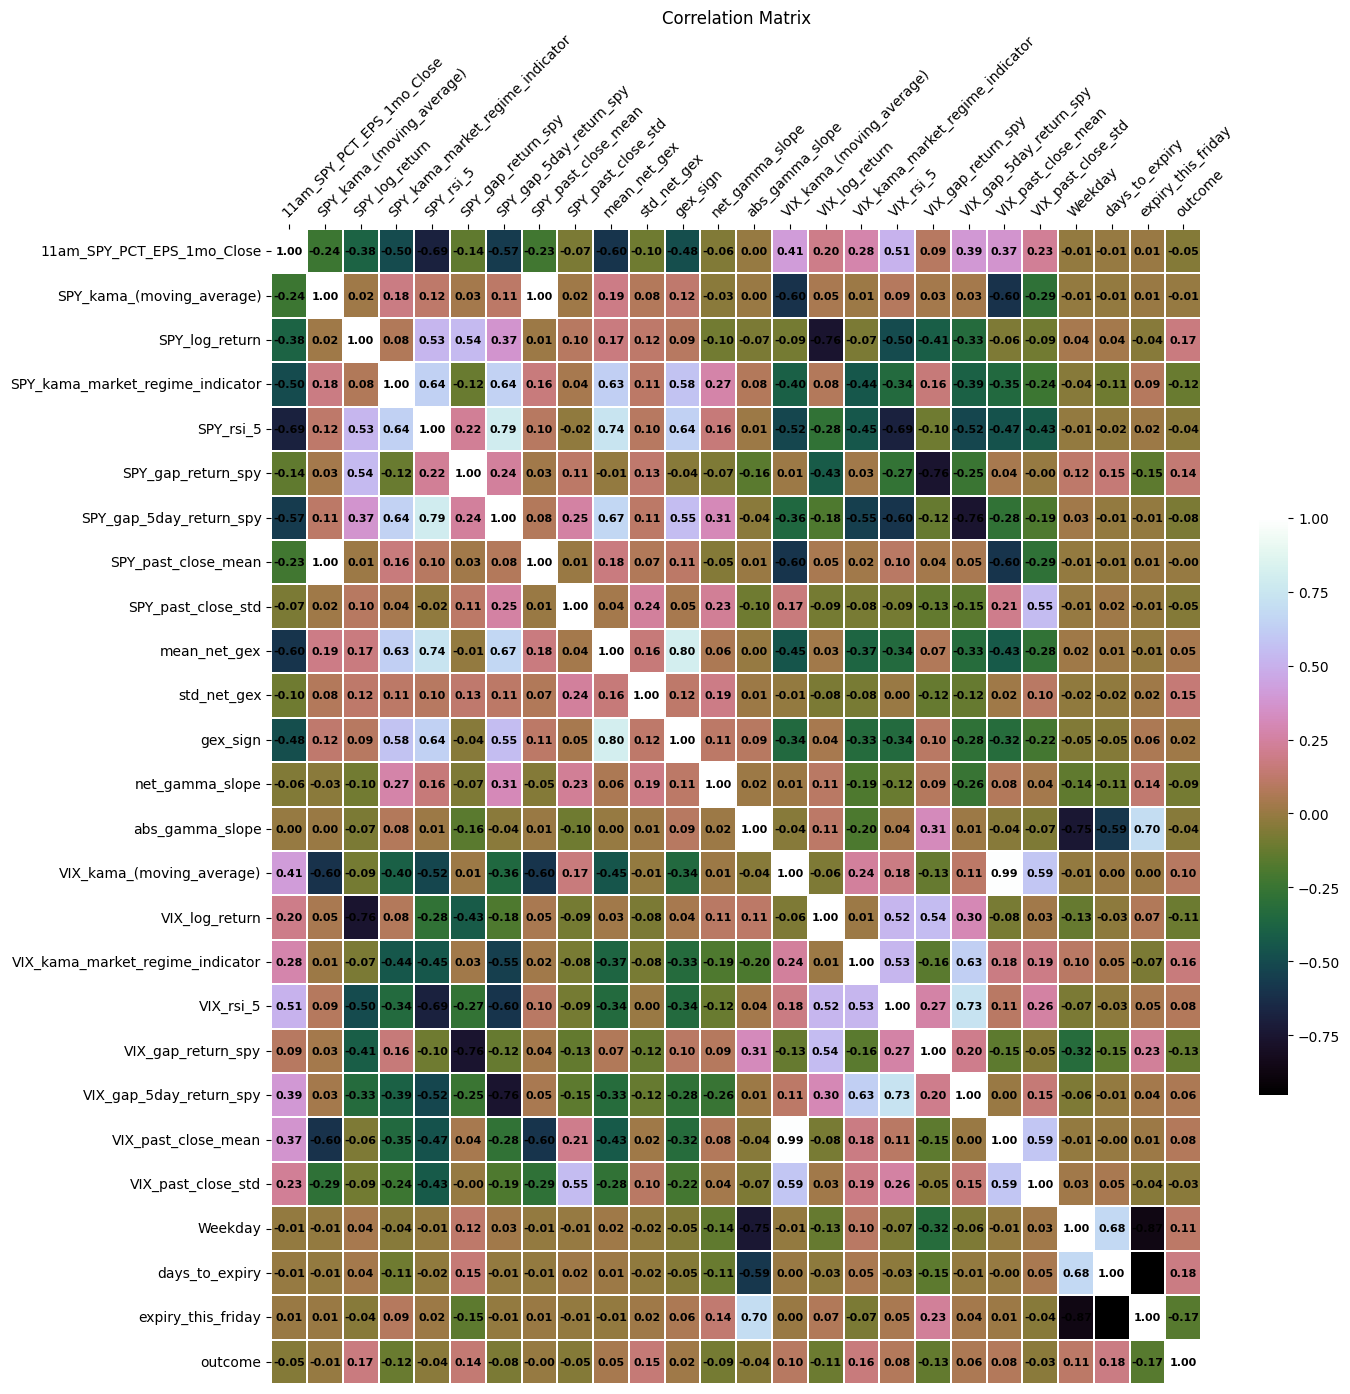

In [499]:
X = train_data.drop(columns=['outcome'])
y = train_data['outcome']

dfc = pd.concat((X,y), axis=1)

correlation = dfc.corr()

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
heatmap = sns.heatmap(correlation, vmax=1,annot=True,cmap='cubehelix',annot_kws={"size": 8,"color": "black","weight": "bold"},
fmt=".2f",  square=False, linewidths=0.1, cbar_kws={"shrink": 0.5},)
heatmap.xaxis.tick_top()
plt.xticks(rotation=45,ha='left',rotation_mode='anchor',fontsize=10)

The data exhibits very low multicollinearity among the predictors. linear models might suffice as there exist some levels of linear relationships between some of the variables with the outcome.

#### APPLY DATA STANDARDDIZATION

In [500]:
train_data_scaled , test_data_scaled = custom_percentile_scaler(train_data, test_data)

#apply one onehot encoding to train
train_data_scaled_encoded , test_data_scaled_encoded = apply_one_hot_encode(train_data_scaled, test_data_scaled, ['Weekday','days_to_expiry'])

train_data_scaled_encoded.columns

Index(['11am_SPY_PCT_EPS_1mo_Close', 'SPY_kama_(moving_average)',
       'SPY_log_return', 'SPY_kama_market_regime_indicator', 'SPY_rsi_5',
       'SPY_gap_return_spy', 'SPY_gap_5day_return_spy', 'SPY_past_close_mean',
       'SPY_past_close_std', 'mean_net_gex', 'std_net_gex', 'gex_sign',
       'net_gamma_slope', 'abs_gamma_slope', 'VIX_kama_(moving_average)',
       'VIX_log_return', 'VIX_kama_market_regime_indicator', 'VIX_rsi_5',
       'VIX_gap_return_spy', 'VIX_gap_5day_return_spy', 'VIX_past_close_mean',
       'VIX_past_close_std', 'outcome', 'expiry_this_friday', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'days_to_expiry_2',
       'days_to_expiry_3', 'days_to_expiry_4', 'days_to_expiry_6',
       'days_to_expiry_7', 'days_to_expiry_8'],
      dtype='object')

#### FEATURE SELECTION

##### REMOVE CONSTANT, QUASI-CONSTANT AND DUPLICATE COLUMNS

In [501]:
#Drop duplicate columns
drop_duplicates = DropDuplicateFeatures()
X_train_clean = drop_duplicates.fit_transform(train_data_scaled_encoded)
X_test_clean = drop_duplicates.transform(test_data_scaled_encoded)
print("Dropped duplicate columns:", drop_duplicates.features_to_drop_)

#Drop constant or quasi-constant columns
drop_constant = DropConstantFeatures(tol=0.98)
X_train_clean = drop_constant.fit_transform(X_train_clean)
X_test_clean = drop_constant.transform(X_test_clean)
print("Dropped constant/quasi-constant columns:", drop_constant.features_to_drop_)

#Drop highly correlated columns
drop_corr = DropCorrelatedFeatures(method='pearson', threshold=0.8)
X_train_clean = drop_corr.fit_transform(X_train_clean)
X_test_clean = drop_corr.transform(X_test_clean)
print("Dropped correlated columns:", drop_corr.features_to_drop_)


Dropped duplicate columns: {'days_to_expiry_8'}
Dropped constant/quasi-constant columns: ['days_to_expiry_6']
Dropped correlated columns: ['SPY_past_close_mean', 'VIX_past_close_mean', 'mean_net_gex']


##### PERFORM FEATURE SELECTION USING RECURSIVE FEATURE ELIMINATION METHOD

In [502]:
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = LogisticRegression(n_jobs=-1,class_weight='balanced', random_state=42)

#defined the X and y components
X = X_train_clean.drop(columns=['outcome'])
y = X_train_clean['outcome']

#Instantiate the RFECV model and fit afterwards
rfecv = RFECV(estimator=model, step=1, cv=tscv, scoring='accuracy')
rfecv.fit(X, y)
selected_features = X.columns[rfecv.support_]
print(selected_features)

Index(['11am_SPY_PCT_EPS_1mo_Close', 'SPY_log_return',
       'SPY_kama_market_regime_indicator', 'SPY_rsi_5', 'SPY_gap_return_spy',
       'SPY_gap_5day_return_spy', 'SPY_past_close_std', 'std_net_gex',
       'gex_sign', 'net_gamma_slope', 'abs_gamma_slope',
       'VIX_kama_(moving_average)', 'VIX_log_return',
       'VIX_kama_market_regime_indicator', 'VIX_rsi_5', 'VIX_gap_return_spy',
       'VIX_gap_5day_return_spy', 'VIX_past_close_std', 'expiry_this_friday',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'days_to_expiry_2',
       'days_to_expiry_3', 'days_to_expiry_7'],
      dtype='object')


#### MODEL BUILDING

In [503]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1,class_weight='balanced', random_state=42)))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
#

#scoring
precision = make_scorer(precision_score, average='macro')
recall = make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')

#### CROSS VALIDATION

In [504]:

df_copy = X_train_clean.copy()

# Drop rows with inf values (check only numeric columns)
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

X = df_copy[selected_features].iloc[:]
y = df_copy['outcome'].iloc[:]

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    #kfold = KFold(n_splits=num_folds)
    tscv = TimeSeriesSplit(n_splits=5)
    #converted mean squared error to positive. Thelower the better
    cv_results = cross_val_score(model, X, y, cv=tscv, scoring=f1)
    kfold_results.append(cv_results)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.603990 (0.090233)
CART: 0.501819 (0.035263)
NB: 0.600772 (0.025798)
LDA: 0.570338 (0.048378)
KNN: 0.539527 (0.033688)


#### EVALUATE CROSS VALIDATION RESULT

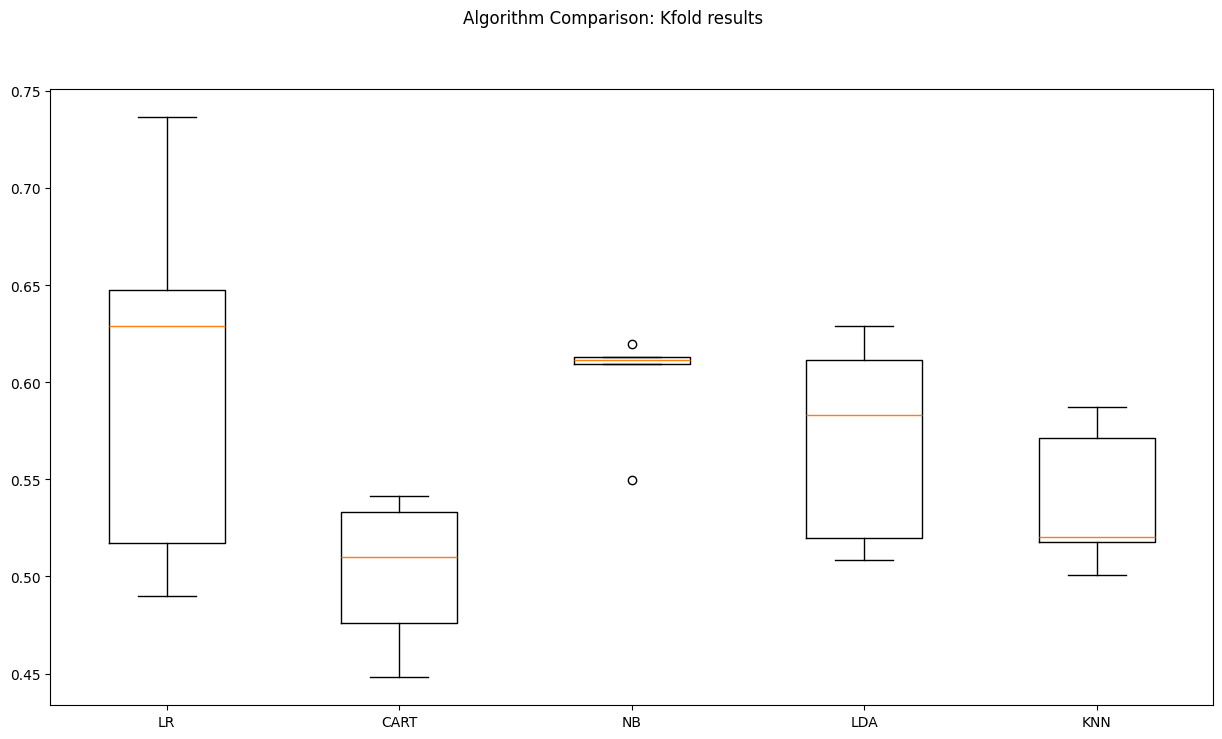

In [505]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

The best performing models are the linear discriminant(LDA) , linear regression and Naive bayes. While performance exhibits variability between 47% and 75%, average expected f1 score performs better than a random model 0f 50%

#### MODEL TUNING (LOGISTIC REGRESSION)

The logistic regression model is tuned to access the best model parameters

In [506]:
# Define hyperparameter grid for Logistic Regression
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']   # Regularization types
solver = ['liblinear', 'saga']

param_grid = dict(C=C, penalty=penalty, solver=solver)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Define scoring metric
scoring = 'f1_macro'

# Set up GridSearchCV
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv, n_jobs=-1)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.588124 using {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


#### MODEL TUNING (NAIVE BAYES)

#### MODEL TESTING WITH UNSEEN DATASET (LOGISTIC REGRESSION)

In [507]:
#train set
df_copy = X_train_clean.copy()
x = df_copy[selected_features].iloc[:]
y = df_copy['outcome'].iloc[:]

#unseen test set
df_test_final = X_test_clean.copy()
X_unseen_test = df_test_final[selected_features].iloc[:]
y_unseen_test = df_test_final['outcome'].iloc[:]

#INSTANTIATE AND TRAIN MODEL
model = LogisticRegression(C=0.1, penalty= 'l2', solver='liblinear',class_weight='balanced',random_state=42)
model.fit(X, y)


##PREDICT TEST SET
y_pred = model.predict(X_unseen_test)


##CHECK RESULTS
# Classification report (includes precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_unseen_test, y_pred))

# If you want them separately:
precision_macro = precision_score(y_unseen_test, y_pred, average='macro')
recall_macro = recall_score(y_unseen_test, y_pred, average='macro')
f1_macro = f1_score(y_unseen_test, y_pred, average='macro')

print(f'Accuracy: {accuracy_score(y_unseen_test, y_pred)}')
print("\nConfusion Matrix:")
print(confusion_matrix(y_unseen_test, y_pred))
print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        68
           1       0.45      0.51      0.48        61

    accuracy                           0.47       129
   macro avg       0.47      0.47      0.47       129
weighted avg       0.48      0.47      0.47       129

Accuracy: 0.4728682170542636

Confusion Matrix:
[[30 38]
 [30 31]]

Macro Precision: 0.4746
Macro Recall: 0.4747
Macro F1 Score: 0.4728
